<a href="https://colab.research.google.com/github/Julia2505/PDD/blob/master/Transfer_learning_with_siamese_fe(07_12_2019).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with base siamese network as feature extractor and SLP as classifier

Cloning the repo
At first we will clone the repository.

In [0]:
!rm -r -f pdd_new
!git clone https://github.com/AlexanderUzhinskiy/pdd_new.git

Cloning into 'pdd_new'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 278 (delta 0), reused 0 (delta 0), pack-reused 273
Receiving objects: 100% (278/278), 53.90 MiB | 11.32 MiB/s, done.
Resolving deltas: 100% (165/165), done.


Change the directory to PDD to get access of helper functions and classes.

In [0]:
import os
os.chdir('pdd_new')
# verify if we are in correct directory
os.listdir()

['.gitignore', 'server', 'README.md', '.git', 'examples', 'pdd']

Download the trained feature extractor from Google Drive

In [0]:
from google.colab import drive
from keras.models import load_model

drive.mount('/gdrive')
!cp "/gdrive/My Drive/pdd_model_086/pdd_feature_extractor.h5" "pdd_feature_extractor.h5"
feature_extractor = load_model("pdd_feature_extractor.h5")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive














/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Constructing new model (run twice...)

In [0]:
from keras.models import Model
from keras.layers import Dense
from keras.layers import Dropout
N_CLASSES=15

x = Dense(256, activation='relu')(feature_extractor.output)
x = Dropout(0.2)(x)
preds=Dense(N_CLASSES, activation='softmax')(x)

model=Model(inputs=feature_extractor.input,outputs=preds)
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 247, 247, 32)      9632      
_________________________________________________________________
activation_1 (Activation)    (None, 247, 247, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 247, 247, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 123, 123, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 117, 117, 64)      100416    
__________

Freezing layers

In [0]:
for layer in model.layers[:-3]:
    layer.trainable=False

We load it and split on train and test subdirectories in place.

In [0]:
from pdd.utils.data_utils import create_dataset_from_dir
from pdd.datasets.grape import load_data

train_data_path, test_data_path = load_data(path='crops_nn.tar', origin="http://pdd.jinr.ru/crops_nn.tar", split_on_train_test=True, random_state=13)

print("Loading datasets...")
train_dataset = create_dataset_from_dir(train_data_path, shuffle=True)
test_dataset = create_dataset_from_dir(test_data_path, shuffle=True)

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of cbc74aef6e5f20ef22b41d1f0f77e40567e6fd1f4e2c007341df9fb4672c3fd8 so we will re-download the data.


100%|███████████████████| 15/15 [00:00<00:00, 164.12it/s]

Splitting on train and test...
Loading datasets...


Load SGD optimizer

In [0]:
import numpy as np
from keras.optimizers import Adam
from keras.utils import to_categorical


adam = Adam(lr=0.0002)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

train_categorical = np.eye(N_CLASSES)[train_dataset['target']]
test_categorical  = np.eye(N_CLASSES)[test_dataset['target']]

history=model.fit(x=train_dataset['data'],
          y=train_categorical, 
          batch_size=32,
          epochs=100,
          validation_data=(test_dataset['data'], test_categorical),
          shuffle=True)


Train on 447 samples, validate on 70 samples
Epoch 1/100
447/447 [==============================] - 1s 3ms/step - loss: 2.1120 - acc: 0.3736 - val_loss: 1.3590 - val_acc: 0.7714
Epoch 2/100
447/447 [==============================] - 1s 2ms/step - loss: 1.1395 - acc: 0.8054 - val_loss: 0.7038 - val_acc: 0.9429
Epoch 3/100
447/447 [==============================] - 1s 2ms/step - loss: 0.6173 - acc: 0.9329 - val_loss: 0.3939 - val_acc: 0.9714
Epoch 4/100
447/447 [==============================] - 1s 2ms/step - loss: 0.3765 - acc: 0.9485 - val_loss: 0.2615 - val_acc: 0.9714
Epoch 5/100
447/447 [==============================] - 1s 2ms/step - loss: 0.2647 - acc: 0.9664 - val_loss: 0.2105 - val_acc: 0.9714
Epoch 6/100
447/447 [==============================] - 1s 2ms/step - loss: 0.1945 - acc: 0.9799 - val_loss: 0.1800 - val_acc: 0.9714
Epoch 7/100
447/447 [==============================] - 1s 2ms/step - loss: 0.1508 - acc: 0.9754 - val_loss: 0.1691 - val_acc: 0.9714
Epoch 8/100
447/447 [===

Saving model to drive

In [0]:
model.save('/gdrive/My Drive/test/pdd_classifier_all_100x100_epochs_4.h5')


metrics of the model

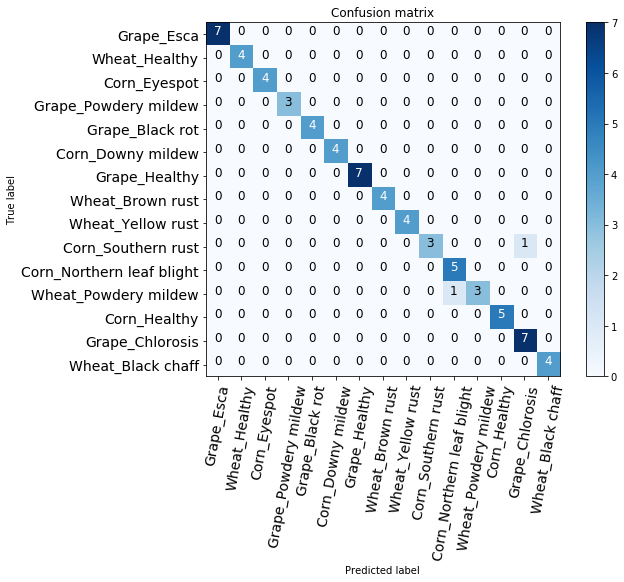

In [0]:
from pdd.utils.metrics_vis import plot_incorrect_predictions
from pdd.utils.metrics_vis import plot_confusion_matrix
from pdd.utils.metrics_vis import plot_embeddings

preds = model.predict(test_dataset['data'])
preds.argmax(axis=1)

preds.argmax(axis=1)==test_dataset['target']

plot_confusion_matrix(y_true=test_dataset['target'], 
                      y_pred=preds.argmax(axis=1),
                      target_names=test_dataset['target_names'],savefig=True)

Incorrect predictions

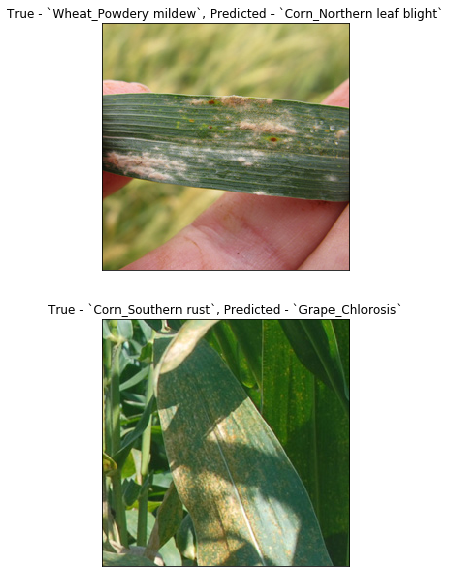

In [0]:
from pdd.utils.metrics_vis import plot_incorrect_predictions
plot_incorrect_predictions(imgs=test_dataset['data'], 
                           y_true=test_dataset['target'],
                           y_pred=preds.argmax(axis=1),
                           target_names=test_dataset['target_names'],
                           savefig=True)

tSNE embeddings

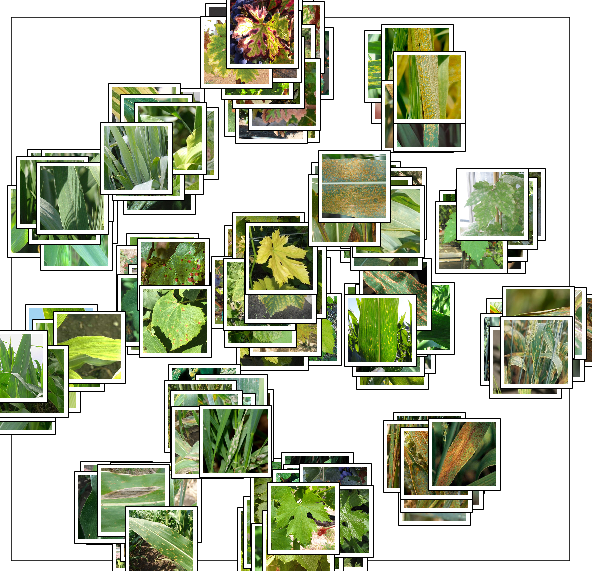

In [0]:
# get the whole dataset including train and test
all_data = np.vstack([train_dataset['data'], test_dataset['data']])
all_labels = np.concatenate([train_dataset['target'], test_dataset['target']])
# rescale input to high-level feature extractor representation
all_data_rescaled = feature_extractor.predict(all_data)
# plot embeddings
plot_embeddings(X=all_data_rescaled,
                y=all_labels,
                X_origin=all_data,
                show_as_imgs=True,
                savefig=True)

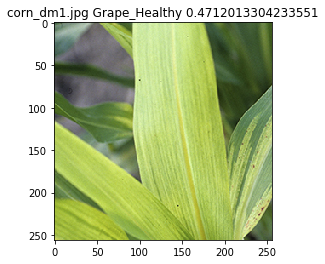

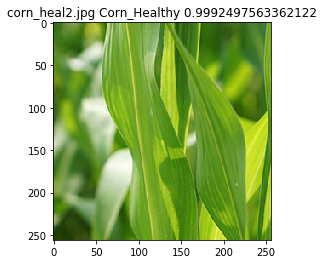

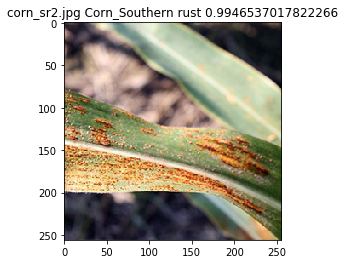

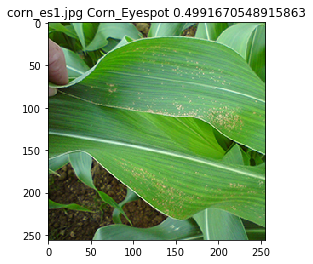

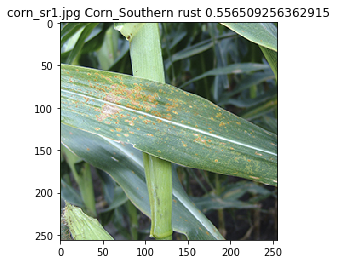

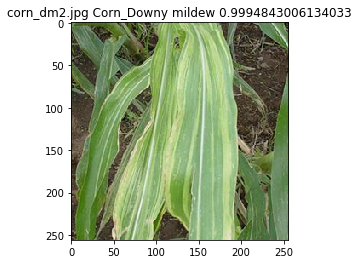

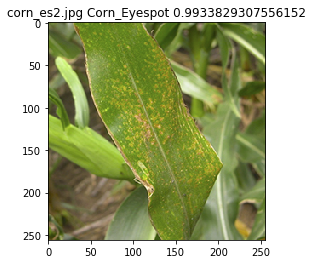

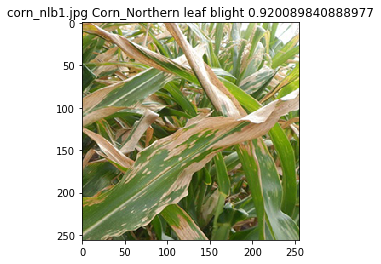

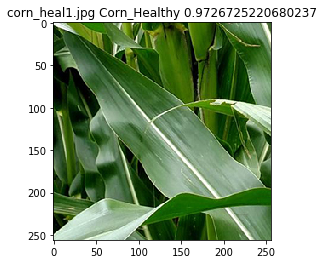

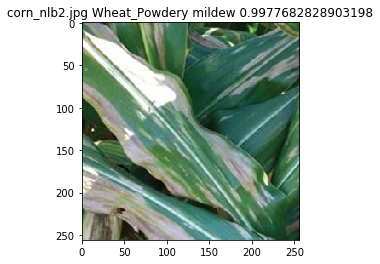

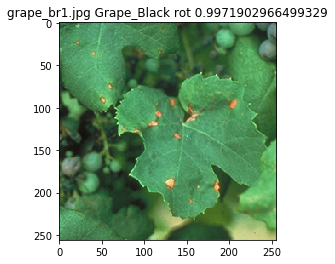

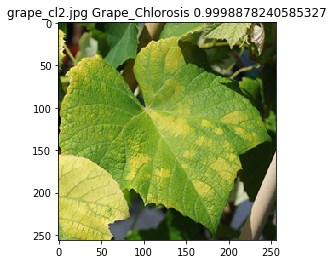

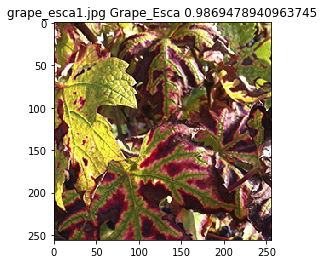

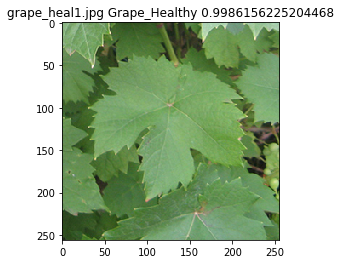

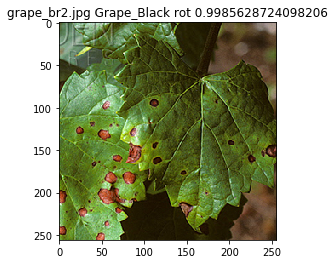

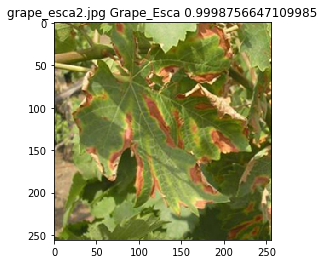

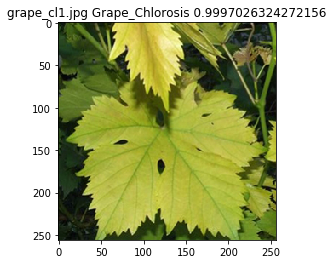

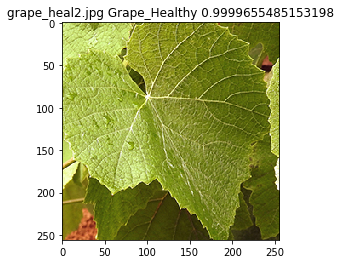

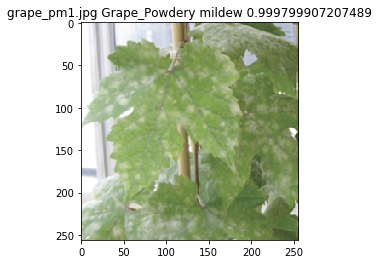

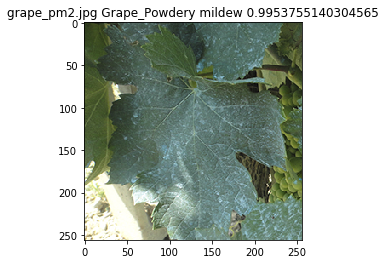

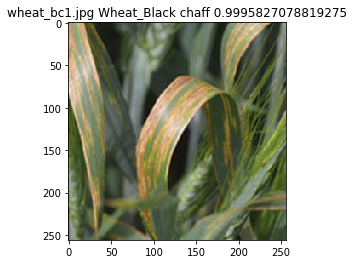

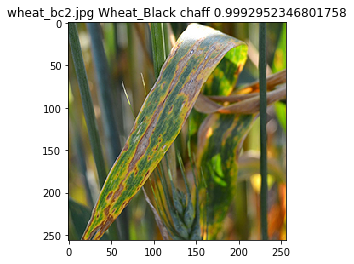

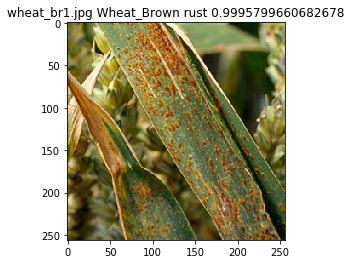

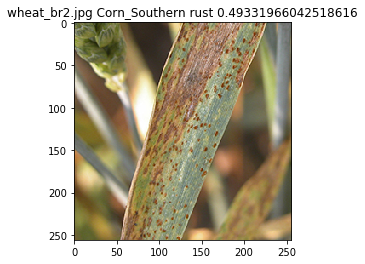

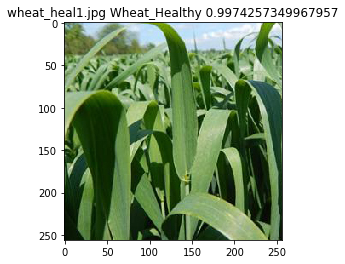

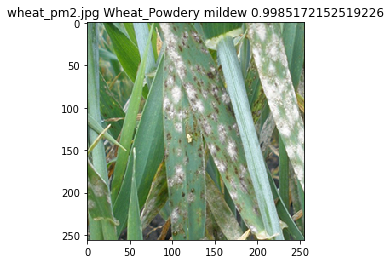

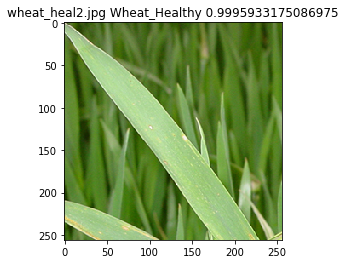

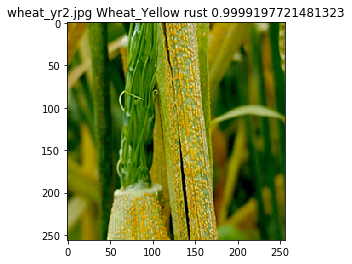

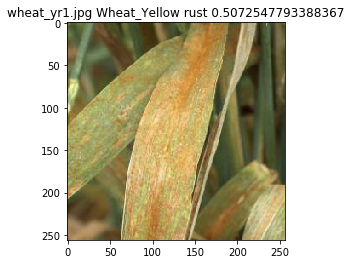

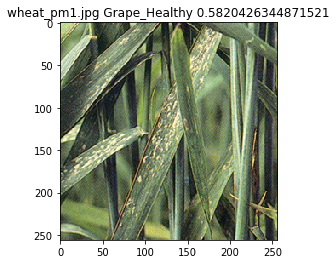

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from keras.preprocessing import image

CLASSES = 
]

img_dir='/gdrive/My Drive/test_dataset/'
for i,img_n in enumerate(os.listdir(img_dir)):
  img = imread(os.path.join(img_dir,img_n))
  plt.imshow(img)
  img = img / 255.
  img = np.expand_dims(img, axis=0)
  result=model.predict(img)
  r = result.tolist()
  prediction = int(np.argmax(result))
  plt.title(str(img_n) + " " + CLASSES[prediction] + " " +  str(r[0][prediction]))
  plt.show()

## single img
#image_path="/gdrive/My Drive/test_dataset//grape_br2.jpg"
#img = imread(image_path)
#plt.imshow(img)
#img = img / 255.
#img = np.expand_dims(img, axis=0)
#result=model.predict(img)
#r = result.tolist()
#prediction = int(np.argmax(result))
#plt.title(CLASSES[prediction] + " " +  str(r[0][prediction]))
#plt.show()